Import all neccessary packages

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from pandas.io.pytables import DataCol
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

Import data from excel file

In [2]:
data = pd.read_excel('./Zebras_Assumption_data.xlsx',
              sheet_name='Assumptions.all')

data

,file,q25,q50,q75,fpeak,duration,am.var,am.rate,am.extent,harmonicity
0,05011.squeal.trim.wav,1.024,22.542,144.346,509.753,0.234,203.701,25.684,7.931,10.16
1,05073.squeal.trim.wav,4.626,391.921,635.612,537.097,0.155,204.375,16.133,12.668,20.27
2,05074.squeal.trim.wav,9.773,558.276,806.924,769.535,0.087,243.896,5.745,42.452,17.58
3,18023.squeal.trim.wav,378.288,439.051,489.999,442.747,0.165,245.843,9.098,27.022,13.51
4,19002.squeal.trim.wav,414.270,485.271,627.478,449.798,0.138,225.379,18.142,12.423,13.93
...,...,...,...,...,...,...,...,...,...,...
408,83033.snort.trim.wav,2.413,33.731,162.388,689.083,0.303,413.913,34.701,11.928,6.15
409,83035.snort.trim.wav,12.324,106.265,286.088,181.432,0.169,386.167,29.581,13.054,8.15
410,83051.snort.trim.wav,1.511,47.826,302.461,197.067,0.549,393.041,25.510,15.407,4.52
411,83053.snort.trim.wav,4.978,70.706,211.919,94.333,0.669,477.292,29.899,15.963,7.78


Use regex to determine the labels for each row of data   
Add the 'labels' as a column in the dataframe   
Remove the now redundant 'file' column

In [3]:
labels = []
for i in data['file']:
  y = re.findall('whinnie|snort|softsnort|squeal', i)
  labels.append(y)
data[['labels']] = labels
data.drop("file", axis=1, inplace = True)
data

,q25,q50,q75,fpeak,duration,am.var,am.rate,am.extent,harmonicity,labels
0,1.024,22.542,144.346,509.753,0.234,203.701,25.684,7.931,10.16,squeal
1,4.626,391.921,635.612,537.097,0.155,204.375,16.133,12.668,20.27,squeal
2,9.773,558.276,806.924,769.535,0.087,243.896,5.745,42.452,17.58,squeal
3,378.288,439.051,489.999,442.747,0.165,245.843,9.098,27.022,13.51,squeal
4,414.270,485.271,627.478,449.798,0.138,225.379,18.142,12.423,13.93,squeal
...,...,...,...,...,...,...,...,...,...,...
408,2.413,33.731,162.388,689.083,0.303,413.913,34.701,11.928,6.15,snort
409,12.324,106.265,286.088,181.432,0.169,386.167,29.581,13.054,8.15,snort
410,1.511,47.826,302.461,197.067,0.549,393.041,25.510,15.407,4.52,snort
411,4.978,70.706,211.919,94.333,0.669,477.292,29.899,15.963,7.78,snort


Define X and Y   
X: All the features / variables  
Y: The label

In [4]:
X = data.drop('labels', axis = 1)
Y = data['labels']

Split X and Y into TRAIN and TEST sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, train_size = 0.7,stratify=Y)

Find and plot the permutation importance of each feature 

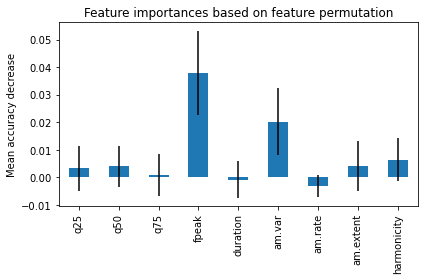

In [7]:
feature_names = list(X.columns)
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances based on feature permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Finalise the important features by taking those with scores higher than the average score

In [7]:
total = 0
for feature_score in forest_importances:
    total += feature_score
average = total / len(forest_importances)

feature_importance_series = pd.Series(forest_importances, index=X_train.columns)


In [11]:
impt_features_list = feature_importance_series[forest_importances >= average].index
X_train = X_train[impt_features_list]
X_test = X_test[impt_features_list]
print(f'The important features are {list(impt_features_list)}')

The important features are ['q50', 'fpeak', 'duration', 'am.var', 'harmonicity']


Use GridSearch to tune hyperparameters

In [12]:
#number of trees
n_estimators = list(range(1,51)) 
#min number of sample in each leaf
min_samples_split =  list(range(15,25))
#max number level of questions in each tree
max_depth = list(range(2, 6))

#hyperparam tuning
params_grid = {
    'n_estimators' : n_estimators,
    'min_samples_split': min_samples_split,
    'max_depth': max_depth
}

grid_model = RandomForestClassifier(random_state=42)

GridSearch = GridSearchCV(grid_model, 
                          params_grid, 
                          cv=5, 
                          return_train_score=True, 
                          refit=True, 
                          verbose=5
                         )
GridSearch.fit(X_train, y_train)
GridSearch_results = pd.DataFrame(GridSearch.cv_results_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
[CV 1/5] END max_depth=2, min_samples_split=15, n_estimators=1; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=15, n_estimators=1; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=15, n_estimators=1; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=15, n_estimators=1; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=15, n_estimators=1; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=15, n_estimators=2; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=15, n_estimators=2; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=15, n_estimators=2; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=15, n_estimators=2; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=15, n_estimators=2; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=15, n_estimators=3; total time=   0.0s
[CV 2/5] END max_dept

[CV 5/5] END max_depth=2, min_samples_split=15, n_estimators=20; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=15, n_estimators=21; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=15, n_estimators=21; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=15, n_estimators=21; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=15, n_estimators=21; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=15, n_estimators=21; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=15, n_estimators=22; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=15, n_estimators=22; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=15, n_estimators=22; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=15, n_estimators=22; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=15, n_estimators=22; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=15, n_estimators=23; total time=

[CV 4/5] END max_depth=2, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=15, n_estimators=41; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=15, n_estimators=41; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=15, n_estimators=41; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=15, n_estimators=41; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=15, n_estimators=41; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=15, n_estimators=42; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=15, n_estimators=42; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=15, n_estimators=42; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=15, n_estimators=42; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=15, n_estimators=42; total time=

[CV 1/5] END max_depth=2, min_samples_split=16, n_estimators=11; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=16, n_estimators=11; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=16, n_estimators=11; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=16, n_estimators=11; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=16, n_estimators=11; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=16, n_estimators=12; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=16, n_estimators=12; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=16, n_estimators=12; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=16, n_estimators=12; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=16, n_estimators=12; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=16, n_estimators=13; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=16, n_estimators=13; total time=

[CV 4/5] END max_depth=2, min_samples_split=16, n_estimators=30; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=16, n_estimators=30; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=16, n_estimators=31; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=16, n_estimators=31; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=16, n_estimators=31; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=16, n_estimators=31; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=16, n_estimators=31; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=16, n_estimators=32; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=16, n_estimators=32; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=16, n_estimators=32; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=16, n_estimators=32; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=16, n_estimators=32; total time=

[CV 2/5] END max_depth=2, min_samples_split=16, n_estimators=50; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=16, n_estimators=50; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=16, n_estimators=50; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=16, n_estimators=50; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=17, n_estimators=1; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=17, n_estimators=1; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=17, n_estimators=1; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=17, n_estimators=1; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=17, n_estimators=1; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=17, n_estimators=2; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=17, n_estimators=2; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=17, n_estimators=2; total time=   0.0s


[CV 2/5] END max_depth=2, min_samples_split=17, n_estimators=20; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=17, n_estimators=20; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=17, n_estimators=20; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=17, n_estimators=20; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=17, n_estimators=21; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=17, n_estimators=21; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=17, n_estimators=21; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=17, n_estimators=21; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=17, n_estimators=21; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=17, n_estimators=22; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=17, n_estimators=22; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=17, n_estimators=22; total time=

[CV 1/5] END max_depth=2, min_samples_split=17, n_estimators=40; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=17, n_estimators=40; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=17, n_estimators=40; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=17, n_estimators=40; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=17, n_estimators=40; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=17, n_estimators=41; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=17, n_estimators=41; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=17, n_estimators=41; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=17, n_estimators=41; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=17, n_estimators=41; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=17, n_estimators=42; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=17, n_estimators=42; total time=

[CV 4/5] END max_depth=2, min_samples_split=18, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=18, n_estimators=10; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=18, n_estimators=11; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=18, n_estimators=11; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=18, n_estimators=11; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=18, n_estimators=11; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=18, n_estimators=11; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=18, n_estimators=12; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=18, n_estimators=12; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=18, n_estimators=12; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=18, n_estimators=12; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=18, n_estimators=12; total time=

[CV 3/5] END max_depth=2, min_samples_split=18, n_estimators=30; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=18, n_estimators=30; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=18, n_estimators=30; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=18, n_estimators=31; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=18, n_estimators=31; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=18, n_estimators=31; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=18, n_estimators=31; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=18, n_estimators=31; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=18, n_estimators=32; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=18, n_estimators=32; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=18, n_estimators=32; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=18, n_estimators=32; total time=

[CV 3/5] END max_depth=2, min_samples_split=18, n_estimators=50; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=18, n_estimators=50; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=18, n_estimators=50; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=19, n_estimators=1; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=19, n_estimators=1; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=19, n_estimators=1; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=19, n_estimators=1; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=19, n_estimators=1; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=19, n_estimators=2; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=19, n_estimators=2; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=19, n_estimators=2; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=19, n_estimators=2; total time=   0.0s
[

[CV 2/5] END max_depth=2, min_samples_split=19, n_estimators=20; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=19, n_estimators=20; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=19, n_estimators=20; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=19, n_estimators=20; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=19, n_estimators=21; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=19, n_estimators=21; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=19, n_estimators=21; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=19, n_estimators=21; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=19, n_estimators=21; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=19, n_estimators=22; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=19, n_estimators=22; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=19, n_estimators=22; total time=

[CV 5/5] END max_depth=2, min_samples_split=19, n_estimators=39; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=19, n_estimators=40; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=19, n_estimators=40; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=19, n_estimators=40; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=19, n_estimators=40; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=19, n_estimators=40; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=19, n_estimators=41; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=19, n_estimators=41; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=19, n_estimators=41; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=19, n_estimators=41; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=19, n_estimators=41; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=19, n_estimators=42; total time=

[CV 1/5] END max_depth=2, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=20, n_estimators=11; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=20, n_estimators=11; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=20, n_estimators=11; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=20, n_estimators=11; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=20, n_estimators=11; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=20, n_estimators=12; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=20, n_estimators=12; total time=

[CV 1/5] END max_depth=2, min_samples_split=20, n_estimators=30; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=20, n_estimators=30; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=20, n_estimators=30; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=20, n_estimators=30; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=20, n_estimators=30; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=20, n_estimators=31; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=20, n_estimators=31; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=20, n_estimators=31; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=20, n_estimators=31; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=20, n_estimators=31; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=20, n_estimators=32; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=20, n_estimators=32; total time=

[CV 4/5] END max_depth=2, min_samples_split=20, n_estimators=49; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=20, n_estimators=49; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=21, n_estimators=1; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=21, n_estimators=1; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=21, n_estimators=1; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=21, n_estimators=1; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=21, n_estimators=1; total time=   0.

[CV 3/5] END max_depth=2, min_samples_split=21, n_estimators=19; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=21, n_estimators=19; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=21, n_estimators=19; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=21, n_estimators=20; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=21, n_estimators=20; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=21, n_estimators=20; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=21, n_estimators=20; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=21, n_estimators=20; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=21, n_estimators=21; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=21, n_estimators=21; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=21, n_estimators=21; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=21, n_estimators=21; total time=

[CV 1/5] END max_depth=2, min_samples_split=21, n_estimators=39; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=21, n_estimators=39; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=21, n_estimators=39; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=21, n_estimators=39; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=21, n_estimators=39; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=21, n_estimators=40; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=21, n_estimators=40; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=21, n_estimators=40; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=21, n_estimators=40; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=21, n_estimators=40; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=21, n_estimators=41; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=21, n_estimators=41; total time=

[CV 1/5] END max_depth=2, min_samples_split=22, n_estimators=9; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=22, n_estimators=9; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=22, n_estimators=9; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=22, n_estimators=9; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=22, n_estimators=9; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=22, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=22, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=22, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=22, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=22, n_estimators=10; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=22, n_estimators=11; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=22, n_estimators=11; total time=   0.

[CV 4/5] END max_depth=2, min_samples_split=22, n_estimators=28; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=22, n_estimators=28; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=22, n_estimators=29; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=22, n_estimators=29; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=22, n_estimators=29; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=22, n_estimators=29; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=22, n_estimators=29; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=22, n_estimators=30; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=22, n_estimators=30; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=22, n_estimators=30; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=22, n_estimators=30; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=22, n_estimators=30; total time=

[CV 3/5] END max_depth=2, min_samples_split=22, n_estimators=48; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=22, n_estimators=48; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=22, n_estimators=48; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=22, n_estimators=49; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=22, n_estimators=49; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=22, n_estimators=49; total time=   0.1s
[CV 4/5] END max_depth=2, min_samples_split=22, n_estimators=49; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=22, n_estimators=49; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=22, n_estimators=50; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=22, n_estimators=50; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=22, n_estimators=50; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=22, n_estimators=50; total time=

[CV 1/5] END max_depth=2, min_samples_split=23, n_estimators=19; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=23, n_estimators=19; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=23, n_estimators=19; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=23, n_estimators=19; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=23, n_estimators=19; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=23, n_estimators=20; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=23, n_estimators=20; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=23, n_estimators=20; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=23, n_estimators=20; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=23, n_estimators=20; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=23, n_estimators=21; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=23, n_estimators=21; total time=

[CV 4/5] END max_depth=2, min_samples_split=23, n_estimators=38; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=23, n_estimators=38; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=23, n_estimators=39; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=23, n_estimators=39; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=23, n_estimators=39; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=23, n_estimators=39; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=23, n_estimators=39; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=23, n_estimators=40; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=23, n_estimators=40; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=23, n_estimators=40; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=23, n_estimators=40; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=23, n_estimators=40; total time=

[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=8; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=8; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=24, n_estimators=8; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=24, n_estimators=9; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=24, n_estimators=9; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=9; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=9; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=24, n_estimators=9; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=24, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=24, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=10; total time=   0.0s


[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=28; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=28; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=24, n_estimators=28; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=24, n_estimators=29; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=24, n_estimators=29; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=29; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=29; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=24, n_estimators=29; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=24, n_estimators=30; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=24, n_estimators=30; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=30; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=30; total time=

[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=48; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=48; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=24, n_estimators=48; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=24, n_estimators=49; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=24, n_estimators=49; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=49; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=49; total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=24, n_estimators=49; total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=24, n_estimators=50; total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=24, n_estimators=50; total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=24, n_estimators=50; total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=24, n_estimators=50; total time=

[CV 4/5] END max_depth=3, min_samples_split=15, n_estimators=18; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=15, n_estimators=18; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=15, n_estimators=19; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=15, n_estimators=19; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=15, n_estimators=19; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=15, n_estimators=19; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=15, n_estimators=19; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=15, n_estimators=20; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=15, n_estimators=20; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=15, n_estimators=20; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=15, n_estimators=20; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=15, n_estimators=20; total time=

[CV 3/5] END max_depth=3, min_samples_split=15, n_estimators=38; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=15, n_estimators=38; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=15, n_estimators=38; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=15, n_estimators=39; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=15, n_estimators=39; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=15, n_estimators=39; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=15, n_estimators=39; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=15, n_estimators=39; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=15, n_estimators=40; total time=

[CV 1/5] END max_depth=3, min_samples_split=16, n_estimators=8; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=16, n_estimators=8; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=16, n_estimators=8; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=16, n_estimators=8; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=16, n_estimators=8; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=16, n_estimators=9; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=16, n_estimators=9; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=16, n_estimators=9; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=16, n_estimators=9; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=16, n_estimators=9; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=16, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=16, n_estimators=10; total time=   0.0s
[C

[CV 1/5] END max_depth=3, min_samples_split=16, n_estimators=28; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=16, n_estimators=28; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=16, n_estimators=28; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=16, n_estimators=28; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=16, n_estimators=28; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=16, n_estimators=29; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=16, n_estimators=29; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=16, n_estimators=29; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=16, n_estimators=29; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=16, n_estimators=29; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=16, n_estimators=30; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=16, n_estimators=30; total time=

[CV 4/5] END max_depth=3, min_samples_split=16, n_estimators=47; total time=   0.1s
[CV 5/5] END max_depth=3, min_samples_split=16, n_estimators=47; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=16, n_estimators=48; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=16, n_estimators=48; total time=   0.1s
[CV 3/5] END max_depth=3, min_samples_split=16, n_estimators=48; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=16, n_estimators=48; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=16, n_estimators=48; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=16, n_estimators=49; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=16, n_estimators=49; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=16, n_estimators=49; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=16, n_estimators=49; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=16, n_estimators=49; total time=

[CV 4/5] END max_depth=3, min_samples_split=17, n_estimators=17; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=17, n_estimators=17; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=17, n_estimators=18; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=18; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=17, n_estimators=18; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=17, n_estimators=18; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=17, n_estimators=18; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=17, n_estimators=19; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=19; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=17, n_estimators=19; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=17, n_estimators=19; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=17, n_estimators=19; total time=

[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=37; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=17, n_estimators=37; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=17, n_estimators=37; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=17, n_estimators=37; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=17, n_estimators=38; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=38; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=17, n_estimators=38; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=17, n_estimators=38; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=17, n_estimators=38; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=17, n_estimators=39; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=39; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=17, n_estimators=39; total time=

[CV 5/5] END max_depth=3, min_samples_split=18, n_estimators=6; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=18, n_estimators=7; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=18, n_estimators=7; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=18, n_estimators=7; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=18, n_estimators=7; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=18, n_estimators=7; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=18, n_estimators=9; total time=   0.0s
[CV 

[CV 4/5] END max_depth=3, min_samples_split=18, n_estimators=26; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=18, n_estimators=26; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=18, n_estimators=27; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=18, n_estimators=27; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=18, n_estimators=27; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=18, n_estimators=27; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=18, n_estimators=27; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=18, n_estimators=28; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=18, n_estimators=28; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=18, n_estimators=28; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=18, n_estimators=28; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=18, n_estimators=28; total time=

[CV 2/5] END max_depth=3, min_samples_split=18, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=18, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=18, n_estimators=46; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=18, n_estimators=46; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=18, n_estimators=47; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=18, n_estimators=47; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=18, n_estimators=47; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=18, n_estimators=47; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=18, n_estimators=47; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=18, n_estimators=48; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=18, n_estimators=48; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=18, n_estimators=48; total time=

[CV 1/5] END max_depth=3, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=19, n_estimators=17; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=19, n_estimators=17; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=19, n_estimators=17; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=19, n_estimators=17; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=19, n_estimators=17; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=19, n_estimators=18; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=19, n_estimators=18; total time=

[CV 4/5] END max_depth=3, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=19, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=19, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=19, n_estimators=36; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=19, n_estimators=36; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=19, n_estimators=36; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=19, n_estimators=37; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=19, n_estimators=37; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=19, n_estimators=37; total time=   0.1s
[CV 4/5] END max_depth=3, min_samples_split=19, n_estimators=37; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=19, n_estimators=37; total time=

[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=20, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=20, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=6; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=20, n_estimators=6; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=20, n_estimators=7; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=20, n_estimators=7; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=7; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=7; total time=   0.0s
[CV 

[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=20, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=20, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=20, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=26; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=20, n_estimators=26; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=20, n_estimators=27; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=20, n_estimators=27; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=27; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=27; total time=

[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=45; total time=   0.1s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=20, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=20, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=20, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=46; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=20, n_estimators=46; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=20, n_estimators=47; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=20, n_estimators=47; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=20, n_estimators=47; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=20, n_estimators=47; total time=

[CV 4/5] END max_depth=3, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=21, n_estimators=17; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=21, n_estimators=17; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=21, n_estimators=17; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=21, n_estimators=17; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=21, n_estimators=17; total time=

[CV 3/5] END max_depth=3, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=21, n_estimators=36; total time=   0.1s
[CV 2/5] END max_depth=3, min_samples_split=21, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=21, n_estimators=36; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=21, n_estimators=36; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=21, n_estimators=36; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=21, n_estimators=37; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=21, n_estimators=37; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=21, n_estimators=37; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=21, n_estimators=37; total time=

[CV 1/5] END max_depth=3, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=22, n_estimators=7; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=22, n_estimators=7; total time=   0.0s
[CV 

[CV 1/5] END max_depth=3, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=22, n_estimators=27; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=22, n_estimators=27; total time=

[CV 4/5] END max_depth=3, min_samples_split=22, n_estimators=44; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=22, n_estimators=44; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=22, n_estimators=46; total time=

[CV 1/5] END max_depth=3, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=23, n_estimators=17; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=23, n_estimators=17; total time=

[CV 1/5] END max_depth=3, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=23, n_estimators=37; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=23, n_estimators=37; total time=

[CV 4/5] END max_depth=3, min_samples_split=24, n_estimators=4; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=4; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 

[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=24; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=24, n_estimators=27; total time=

[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=44; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_split=24, n_estimators=47; total time=

[CV 4/5] END max_depth=4, min_samples_split=15, n_estimators=14; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=15, n_estimators=14; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=15, n_estimators=16; total time=

[CV 4/5] END max_depth=4, min_samples_split=15, n_estimators=34; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=15, n_estimators=34; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=15, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=15, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=15, n_estimators=36; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=15, n_estimators=36; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=15, n_estimators=36; total time=

[CV 3/5] END max_depth=4, min_samples_split=16, n_estimators=4; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=16, n_estimators=4; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=16, n_estimators=4; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 

[CV 2/5] END max_depth=4, min_samples_split=16, n_estimators=24; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=16, n_estimators=24; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=16, n_estimators=24; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=16, n_estimators=24; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=16, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=16, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=16, n_estimators=26; total time=

[CV 5/5] END max_depth=4, min_samples_split=16, n_estimators=43; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=16, n_estimators=44; total time=   0.1s
[CV 2/5] END max_depth=4, min_samples_split=16, n_estimators=44; total time=   0.1s
[CV 3/5] END max_depth=4, min_samples_split=16, n_estimators=44; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=16, n_estimators=44; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=16, n_estimators=44; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=16, n_estimators=46; total time=

[CV 3/5] END max_depth=4, min_samples_split=17, n_estimators=14; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=17, n_estimators=14; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=17, n_estimators=14; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=17, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=17, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=17, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=17, n_estimators=16; total time=

[CV 1/5] END max_depth=4, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=17, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=17, n_estimators=36; total time=

[CV 1/5] END max_depth=4, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=18, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=18, n_estimators=6; total time=   0.0s
[CV 

[CV 2/5] END max_depth=4, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=18, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=18, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=18, n_estimators=26; total time=

[CV 5/5] END max_depth=4, min_samples_split=18, n_estimators=43; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=18, n_estimators=44; total time=   0.1s
[CV 1/5] END max_depth=4, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=18, n_estimators=46; total time=

[CV 4/5] END max_depth=4, min_samples_split=19, n_estimators=14; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=19, n_estimators=14; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=19, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=19, n_estimators=16; total time=

[CV 2/5] END max_depth=4, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=19, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=19, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=19, n_estimators=36; total time=

[CV 1/5] END max_depth=4, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=20, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=20, n_estimators=6; total time=   0.0s
[CV 

[CV 3/5] END max_depth=4, min_samples_split=20, n_estimators=24; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=20, n_estimators=24; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=20, n_estimators=24; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=20, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=20, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=20, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=20, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=20, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=20, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=20, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=20, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=20, n_estimators=26; total time=

[CV 3/5] END max_depth=4, min_samples_split=20, n_estimators=44; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=20, n_estimators=44; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=20, n_estimators=44; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=20, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=20, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=20, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=20, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=20, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=20, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=20, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=20, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=20, n_estimators=46; total time=

[CV 4/5] END max_depth=4, min_samples_split=21, n_estimators=14; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=21, n_estimators=14; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=21, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=21, n_estimators=16; total time=

[CV 2/5] END max_depth=4, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=21, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=21, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=21, n_estimators=36; total time=

[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=4; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=4; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=4; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 

[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=24; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=24; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=26; total time=

[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=44; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=44; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=46; total time=

[CV 3/5] END max_depth=4, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=23, n_estimators=17; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=23, n_estimators=17; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=23, n_estimators=17; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=23, n_estimators=17; total time=

[CV 1/5] END max_depth=4, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=23, n_estimators=37; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=23, n_estimators=37; total time=

[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=24, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=7; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=7; total time=   0.0s
[CV 

[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=27; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=27; total time=

[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 5/5] END max_depth=4, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 1/5] END max_depth=4, min_samples_split=24, n_estimators=47; total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_split=24, n_estimators=47; total time=

[CV 5/5] END max_depth=5, min_samples_split=15, n_estimators=14; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=15, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=15, n_estimators=16; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=15, n_estimators=17; total time=

[CV 4/5] END max_depth=5, min_samples_split=15, n_estimators=34; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=15, n_estimators=34; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=15, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=15, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=15, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=15, n_estimators=36; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=15, n_estimators=36; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=15, n_estimators=36; total time=

[CV 5/5] END max_depth=5, min_samples_split=16, n_estimators=4; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=16, n_estimators=6; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=16, n_estimators=7; total time=   0.0s
[CV 

[CV 3/5] END max_depth=5, min_samples_split=16, n_estimators=24; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=16, n_estimators=24; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=16, n_estimators=24; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=16, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=16, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=16, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=16, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=16, n_estimators=26; total time=

[CV 2/5] END max_depth=5, min_samples_split=16, n_estimators=44; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=16, n_estimators=44; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=16, n_estimators=44; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=16, n_estimators=44; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=16, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=16, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=16, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=16, n_estimators=46; total time=

[CV 2/5] END max_depth=5, min_samples_split=17, n_estimators=14; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=17, n_estimators=14; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=17, n_estimators=14; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=17, n_estimators=14; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=17, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=17, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=17, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=17, n_estimators=16; total time=

[CV 5/5] END max_depth=5, min_samples_split=17, n_estimators=33; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=17, n_estimators=34; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=17, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=17, n_estimators=36; total time=

[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=18, n_estimators=4; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=18, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=18, n_estimators=6; total time=   0.0s
[CV 

[CV 5/5] END max_depth=5, min_samples_split=18, n_estimators=23; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=18, n_estimators=24; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=18, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=26; total time=

[CV 5/5] END max_depth=5, min_samples_split=18, n_estimators=43; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=18, n_estimators=44; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=18, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=18, n_estimators=46; total time=

[CV 4/5] END max_depth=5, min_samples_split=19, n_estimators=13; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=19, n_estimators=13; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=19, n_estimators=14; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=19, n_estimators=14; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=19, n_estimators=14; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=19, n_estimators=14; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=19, n_estimators=14; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=19, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=19, n_estimators=15; total time=

[CV 2/5] END max_depth=5, min_samples_split=19, n_estimators=33; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=19, n_estimators=33; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=19, n_estimators=33; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=19, n_estimators=33; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=19, n_estimators=34; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=19, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=19, n_estimators=35; total time=

[CV 1/5] END max_depth=5, min_samples_split=20, n_estimators=3; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=20, n_estimators=3; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=20, n_estimators=3; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=20, n_estimators=3; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=20, n_estimators=3; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=20, n_estimators=4; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV 

[CV 4/5] END max_depth=5, min_samples_split=20, n_estimators=22; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=20, n_estimators=22; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=20, n_estimators=23; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=20, n_estimators=23; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=20, n_estimators=23; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=20, n_estimators=23; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=20, n_estimators=23; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=20, n_estimators=24; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=20, n_estimators=24; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=20, n_estimators=24; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=20, n_estimators=24; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=20, n_estimators=24; total time=

[CV 3/5] END max_depth=5, min_samples_split=20, n_estimators=42; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=20, n_estimators=42; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=20, n_estimators=42; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=20, n_estimators=43; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=20, n_estimators=43; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=20, n_estimators=43; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=20, n_estimators=43; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=20, n_estimators=43; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=20, n_estimators=44; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=20, n_estimators=44; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=20, n_estimators=44; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=20, n_estimators=44; total time=

[CV 3/5] END max_depth=5, min_samples_split=21, n_estimators=13; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=21, n_estimators=13; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=21, n_estimators=13; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=21, n_estimators=14; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=21, n_estimators=14; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=21, n_estimators=14; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=21, n_estimators=14; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=21, n_estimators=14; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=21, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=21, n_estimators=15; total time=

[CV 3/5] END max_depth=5, min_samples_split=21, n_estimators=33; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=21, n_estimators=33; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=21, n_estimators=33; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=21, n_estimators=34; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=21, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=21, n_estimators=35; total time=

[CV 2/5] END max_depth=5, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=22, n_estimators=5; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=22, n_estimators=6; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=22, n_estimators=7; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=22, n_estimators=7; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=22, n_estimators=7; total time=   0.0s
[CV 

[CV 5/5] END max_depth=5, min_samples_split=22, n_estimators=24; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=22, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=22, n_estimators=26; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=22, n_estimators=27; total time=

[CV 4/5] END max_depth=5, min_samples_split=22, n_estimators=44; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=22, n_estimators=44; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=22, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=22, n_estimators=46; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=22, n_estimators=46; total time=

[CV 3/5] END max_depth=5, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=23, n_estimators=15; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=23, n_estimators=16; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=23, n_estimators=17; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=23, n_estimators=17; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=23, n_estimators=17; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=23, n_estimators=17; total time=

[CV 1/5] END max_depth=5, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=23, n_estimators=35; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=23, n_estimators=36; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=23, n_estimators=37; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=23, n_estimators=37; total time=

[CV 1/5] END max_depth=5, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=24, n_estimators=6; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=24, n_estimators=7; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=24, n_estimators=7; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=24, n_estimators=7; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=24, n_estimators=7; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=24, n_estimators=7; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=24, n_estimators=8; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=24, n_estimators=8; total time=   0.0s
[CV 

[CV 4/5] END max_depth=5, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=24, n_estimators=25; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=24, n_estimators=26; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=24, n_estimators=27; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=24, n_estimators=27; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=24, n_estimators=27; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=24, n_estimators=27; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=24, n_estimators=27; total time=

[CV 2/5] END max_depth=5, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=24, n_estimators=45; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=24, n_estimators=46; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=24, n_estimators=47; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=24, n_estimators=47; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=24, n_estimators=47; total time=

Add optimal hyperparameters to RandomForestClassifier model  
Predict y with X_test data
Find the accuracy of the optimised model

In [25]:
optimised_clf = GridSearch.best_estimator_
y_pred = optimised_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy score for the test data is {accuracy}")

The accuracy score for the test data is 0.9516129032258065


[Text(0, 0.5, 'snort'),
 Text(0, 1.5, 'softsnort'),
 Text(0, 2.5, 'squeal'),
 Text(0, 3.5, 'whinnie')]

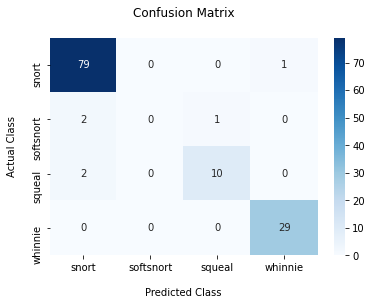

In [32]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('Actual Class\n')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['snort','softsnort', 'squeal', 'whinnie'])
ax.yaxis.set_ticklabels(['snort','softsnort', 'squeal', 'whinnie'])